In [3]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [5]:
save_dir = os.path.join(array_dir, 'noise_galsim')
util.create_directory_if_not_exists(save_dir)
util.clear_directory(save_dir)

In [9]:
band = 'F106'
exposure_time = 146
oversample = 5
num_pix = 45

lens = SampleStrongLens()

# add CDM subhalos; NB same subhalo population for all
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

# generate synthetic image
model = lens.get_array(band=band, num_pix=num_pix * oversample, side=4.95)

# get flux
total_flux_cps = lens.get_total_flux_cps(band)

# get interpolated image
interp = galsim.InterpolatedImage(galsim.Image(model, xmin=0, ymin=0), 
                                  scale=0.11 / oversample,
                                  flux=total_flux_cps * exposure_time)

# get a PSF
detector = 1
detector_pos = (2048, 2048)
psf_kernel = psf.get_webbpsf_psf(band, detector, detector_pos, oversample)

# convolve interpolated image with PSF, then write out at final pixel resolution (0.11"/pixel)
convolved = gs.convolve(interp, psf_kernel, num_pix)

# calculate sky background
wcs_dict = gs.get_wcs(ra=30, dec=-30, date=None)
bkgs = gs.get_sky_bkgs(wcs_dict, band, detector, exposure_time, num_pix)

# add sky background to convolved image
image = convolved + bkgs[band]

# integer number of photons are being detected, so quantize
image.quantize()

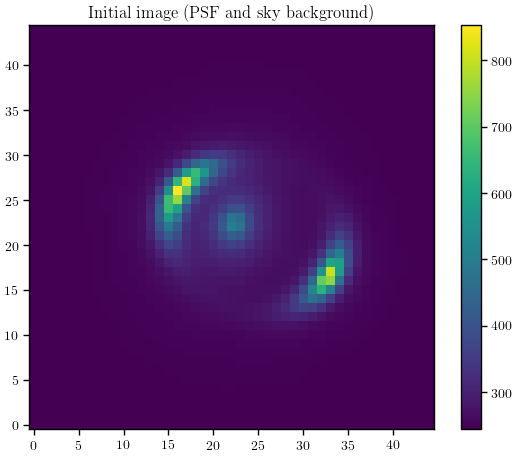

In [9]:
plt.imshow(image.array)
plt.title('Initial image (PSF and sky background)')
plt.colorbar()
plt.show()

In [10]:
np.save(os.path.join(save_dir, '00_initial.npy'), image.array)

The `galsim.roman.allDetectorEffects` method (as of version 2.5) applies the following routines (in order):

1. Poisson noise (`PoissonNoise` then `addNoise`)
2. reciprocity failure (`addReciprocityFailure`)
3. dark current (`Deviatenoise` then `add Noise`)
4. persistence, which we don't include since we don't have previous exposures
5. nonlinearity (`applyNonlinearity`)
6. interpixel capacitance (`applyIPC`)
7. read noise (`GaussianNoise` then `addNoise`)

# Add Poisson noise

In [11]:
prev = deepcopy(image)

seed = 1234
rng = galsim.BaseDeviate(seed)
poisson_noise = galsim.PoissonNoise(rng)
image.addNoise(poisson_noise)

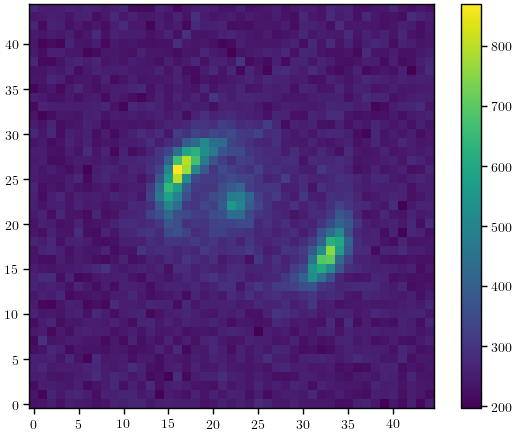

In [12]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

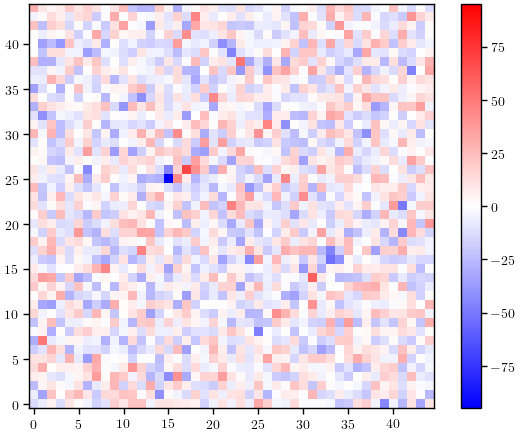

In [13]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [14]:
np.save(os.path.join(save_dir, '01_poisson_noise.npy'), image.array)
np.save(os.path.join(save_dir, 'res_01_poisson_noise.npy'), image.array - prev.array)

# Add reciprocity failure

In [15]:
prev = deepcopy(image)

galsim.roman.addReciprocityFailure(image, exptime=exposure_time)

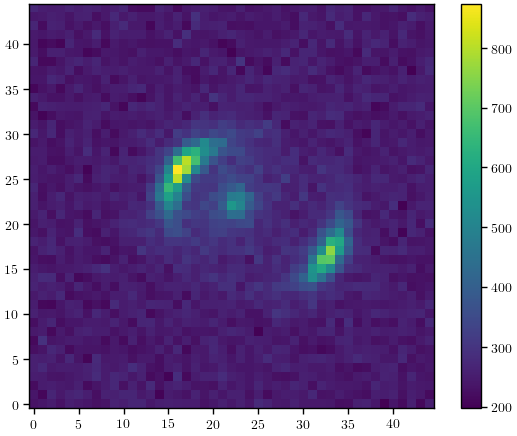

In [16]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

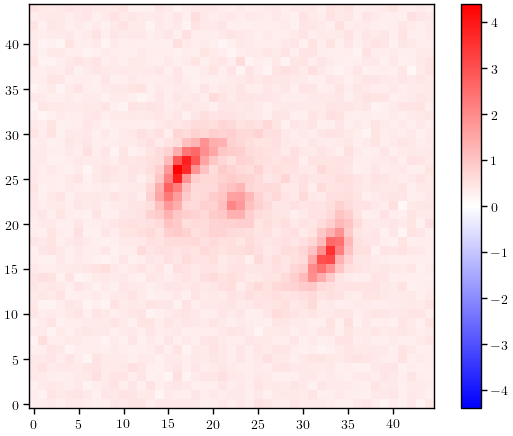

In [17]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [18]:
np.save(os.path.join(save_dir, '02_reciprocity_failure.npy'), image.array)
np.save(os.path.join(save_dir, 'res_02_reciprocity_failure.npy'), image.array - prev.array)

# Add dark current

In [19]:
prev = deepcopy(image)

total_dark_current = galsim.roman.dark_current * exposure_time
dark_noise = galsim.DeviateNoise(galsim.PoissonDeviate(rng, total_dark_current))
image.addNoise(dark_noise)

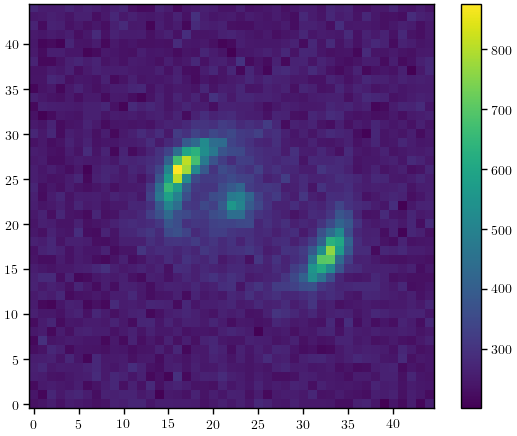

In [20]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

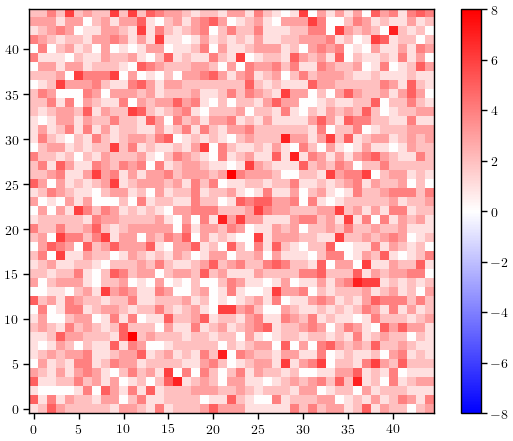

In [21]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [22]:
np.save(os.path.join(save_dir, '03_dark_current.npy'), image.array)
np.save(os.path.join(save_dir, 'res_03_dark_current.npy'), image.array - prev.array)

# Apply nonlinearity

In [23]:
prev = deepcopy(image)

galsim.roman.applyNonlinearity(image)

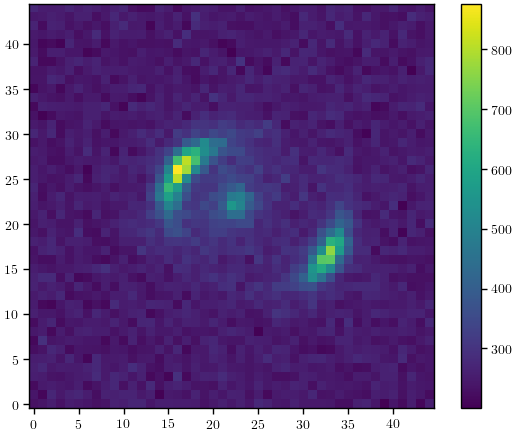

In [24]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

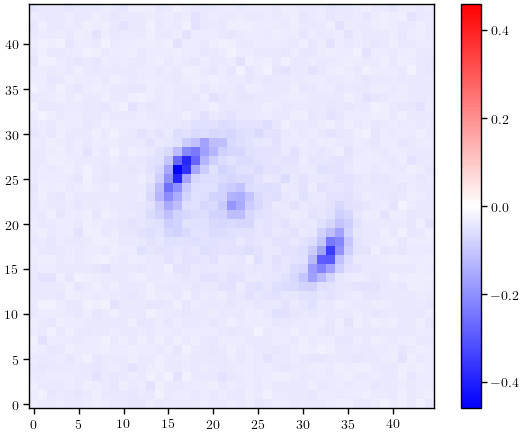

In [25]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [26]:
np.save(os.path.join(save_dir, '04_nonlinearity.npy'), image.array)
np.save(os.path.join(save_dir, 'res_04_nonlinearity.npy'), image.array - prev.array)

# Apply interpixel capacitance

In [27]:
prev = deepcopy(image)

galsim.roman.applyIPC(image)

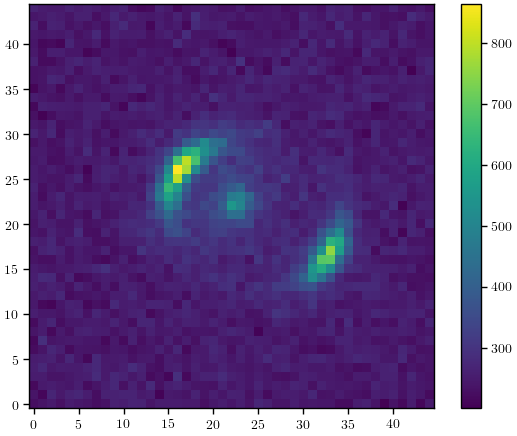

In [28]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

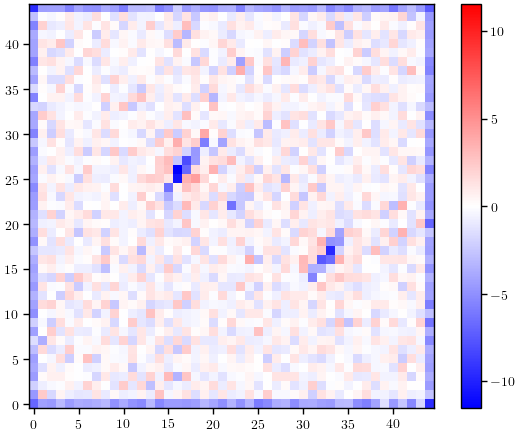

In [29]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [30]:
np.save(os.path.join(save_dir, '05_ipc.npy'), image.array)
np.save(os.path.join(save_dir, 'res_05_ipc.npy'), image.array - prev.array)

# Add read noise

In [31]:
prev = deepcopy(image)

gn = galsim.GaussianNoise(rng, sigma=galsim.roman.read_noise)
image.addNoise(gn)

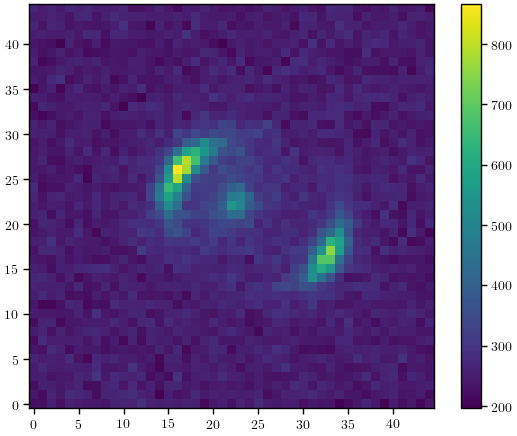

In [32]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

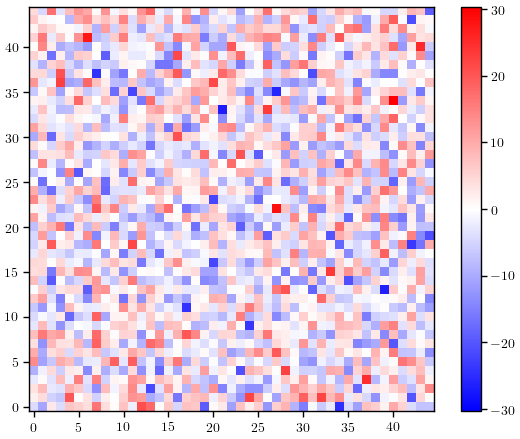

In [33]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [34]:
np.save(os.path.join(save_dir, '06_read_noise.npy'), image.array)
np.save(os.path.join(save_dir, 'res_06_read_noise.npy'), image.array - prev.array)

# Quantize to get final image

In [35]:
prev = deepcopy(image)

image.quantize()

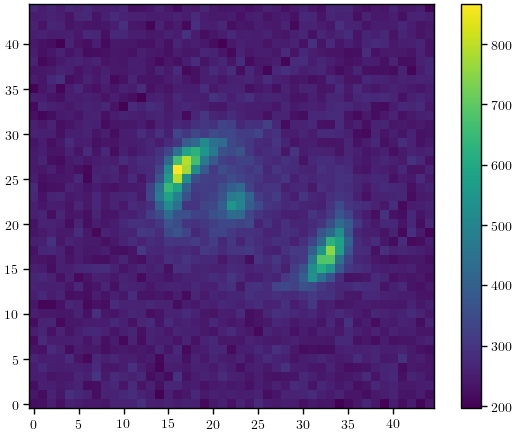

In [36]:
plt.imshow(image.array)
plt.colorbar()
plt.show()

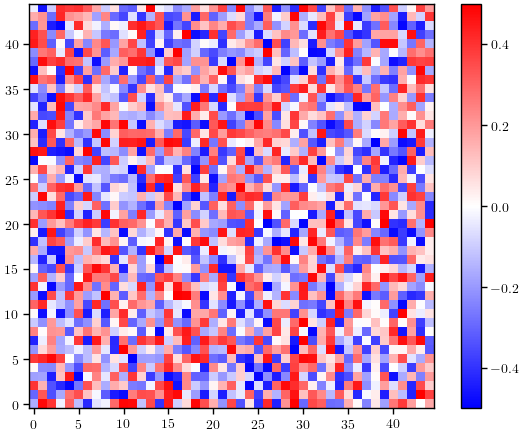

In [37]:
vmax = plot_util.get_v([image.array - prev.array])
plt.imshow(image.array - prev.array, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [38]:
np.save(os.path.join(save_dir, '07_quantize.npy'), image.array)
np.save(os.path.join(save_dir, 'res_07_quantize.npy'), image.array - prev.array)

# Create figure

In [10]:
image_00 = np.load(os.path.join(save_dir, '00_initial.npy'))
image_01 = np.load(os.path.join(save_dir, '01_poisson_noise.npy'))
image_02 = np.load(os.path.join(save_dir, '02_reciprocity_failure.npy'))
image_03 = np.load(os.path.join(save_dir, '03_dark_current.npy'))
image_04 = np.load(os.path.join(save_dir, '04_nonlinearity.npy'))
image_05 = np.load(os.path.join(save_dir, '05_ipc.npy'))
image_06 = np.load(os.path.join(save_dir, '06_read_noise.npy'))
image_07 = np.load(os.path.join(save_dir, '07_quantize.npy'))

res_01 = np.load(os.path.join(save_dir, 'res_01_poisson_noise.npy'))
res_02 = np.load(os.path.join(save_dir, 'res_02_reciprocity_failure.npy'))
res_03 = np.load(os.path.join(save_dir, 'res_03_dark_current.npy'))
res_04 = np.load(os.path.join(save_dir, 'res_04_nonlinearity.npy'))
res_05 = np.load(os.path.join(save_dir, 'res_05_ipc.npy'))
res_06 = np.load(os.path.join(save_dir, 'res_06_read_noise.npy'))
res_07 = np.load(os.path.join(save_dir, 'res_07_quantize.npy'))

In [11]:
image_list = [image_00, image_01, image_02, image_03, image_04, image_05, image_06, image_07]
residual_list = [res_01, res_02, res_03, res_04, res_05, res_06, res_07]
title_list = ['Initial', 'Poisson noise', 'Reciprocity failure', 'Dark current', 'Nonlinearity', 'IPC', 'Read noise', 'Quantized']
alphabet = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

In [12]:
# to be consistent with the rest of the paper, put everything in units of e-/sec/pixel
image_list = [image / exposure_time for image in image_list]
residual_list = [residual / exposure_time for residual in residual_list]

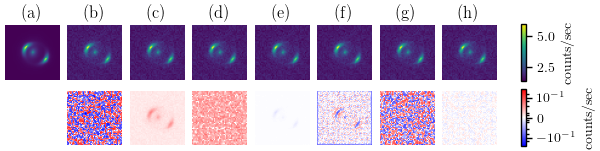

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=len(image_list), figsize=(6, 1.5), constrained_layout=True)

for i, image in enumerate(image_list):
    axis = ax[0][i].imshow(image)
    ax[0][i].set_title(alphabet[i])
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis, ax=ax[0], aspect=10)
cbar.set_label('counts/sec', rotation=90)

norm = plot_util.get_norm(residual_list, linear_width=0.005)

for i, residual in enumerate(residual_list):
    axis = ax[1][i + 1].imshow(residual, cmap='bwr', norm=norm)
    ax[1][i + 1].set_axis_off()

ax[1][0].axis('off')

cbar = fig.colorbar(axis, ax=ax[1], ticks=[-0.1, 0, 0.1], aspect=10)
cbar.set_label('counts/sec', rotation=90)

# arrowprops = dict(arrowstyle="->", color='black')  # linewidth=2, 
# plt.annotate('', xy=(-0.1, 0.5), xycoords=ax[0][0].transAxes, xytext=(1.1, 0.4), textcoords=ax[0][1].transAxes, arrowprops=arrowprops)

plt.savefig(os.path.join(figure_dir, 'noise_galsim.png'))
plt.show()